In [212]:
%reset
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


### Read data, remap polygon numbers to range from 0 to 689 consistent with OAE Atlas conventions.

In [213]:
atlas_data = xr.open_dataset('oae_eff_curves_global.nc')

atlas_r1 = atlas_data.sel(region = 'Atlantic').isel(polygon=np.arange(0,150))
atlas_r2 = atlas_data.sel(region = 'Pacific').isel(polygon=np.arange(0,200))
atlas_r3 = atlas_data.sel(region = 'South').isel(polygon=np.arange(0,300))
atlas_r4 = atlas_data.sel(region = 'Southern_Ocean').isel(polygon=np.arange(0,40))

atlas_full = xr.concat([atlas_r1,atlas_r2,atlas_r3,atlas_r4],dim='polygon').drop_vars('region').drop_vars('polygon').assign_coords(polygon=(np.arange(690)))

In [214]:
print(atlas_full)

<xarray.Dataset>
Dimensions:         (polygon: 690, season: 4, time: 189)
Coordinates:
  * time            (time) object 0347-01-16 12:00:00 ... 0362-09-16 00:00:00
  * season          (season) object 'January' 'April' 'July' 'October'
  * polygon         (polygon) int64 0 1 2 3 4 5 6 ... 684 685 686 687 688 689
Data variables:
    time_delta      (season, time, polygon) float64 31.0 31.0 31.0 ... 30.0 30.0
    OAE_efficiency  (season, polygon, time) float64 0.01463 0.02522 ... 0.7729


### Select polygon index number, read OAE efficiency data for all seasons, create IRF_full library

In [236]:
#Specify index of polygon from OAE Atlas; read in data.
i_polygon = 0;
polygon_data = atlas_full.sel(polygon = i_polygon);
IRF_length   = len(polygon_data.OAE_efficiency[0,:].dropna(dim='time'));

# Specify nyears as maximum alkalinity forcing duration (up to user)
nyears = 5

IRF_lib = pd.DataFrame(np.empty(shape=[IRF_length,13])*np.nan)

#Reading in OAE Global Atlas data, populating IRFs for January, April, July, and October:
IRF_lib[0] = polygon_data.OAE_efficiency[0,:].dropna(dim='time').values;
IRF_lib[3] = polygon_data.OAE_efficiency[1,:].dropna(dim='time').values;
IRF_lib[6] = polygon_data.OAE_efficiency[2,:].dropna(dim='time').values;
IRF_lib[9] = polygon_data.OAE_efficiency[3,:].dropna(dim='time').values;
IRF_lib[12] = polygon_data.OAE_efficiency[0,:].dropna(dim='time').values;


IRF_lib = (IRF_lib.interpolate(axis=1,method='linear')).drop([12],axis=1)
IRF_full = np.transpose(np.tile(np.array(IRF_lib),(1,nyears)))
print(IRF_full.shape)

(60, 180)


Text(0.5, 1.0, ' Polygon 0')

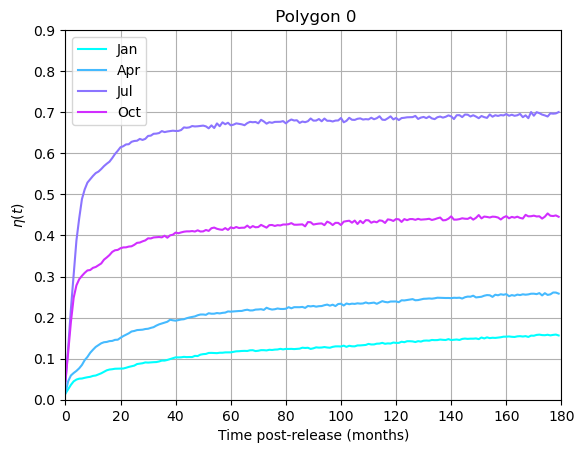

In [237]:
#plt.figure(figsize=(5,3),dpi=150)
colors = (plt.cm.cool(np.linspace(0, 1, 12)))

plt.plot(IRF_full[0],label='Jan',color=colors[0])
plt.plot(IRF_full[3],label='Apr',color=colors[3])
plt.plot(IRF_full[6],label='Jul',color=colors[6])
plt.plot(IRF_full[9],label='Oct',color=colors[9])
plt.legend()
plt.grid(); plt.xlim([0,IRF_length]); plt.ylim([0,0.9]); plt.xlabel('Time post-release (months)'); plt.ylabel('$\eta(t)$'); 

plt.title(' Polygon %i'%(i_polygon))

1
2
3
4
5
6
7
8
9
10
11
12


Text(0.5, 1.0, 'Monthly IRFs for Polygon 0')

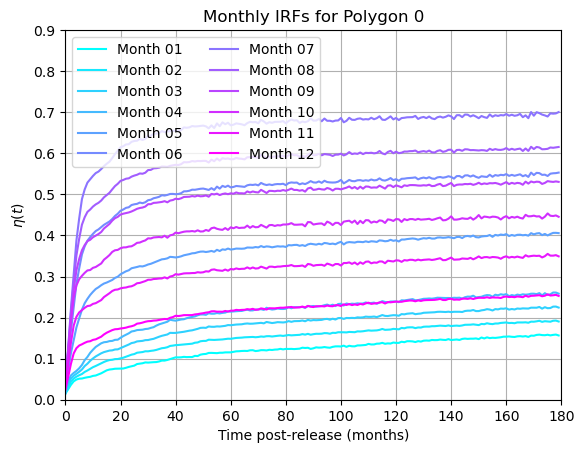

In [238]:
#plt.figure(figsize=(5,3),dpi=150)
colors = (plt.cm.cool(np.linspace(0, 1, 12)))

for i in range(1,13):
    print(i)
    plt.plot(IRF_full[i-1],label=f'Month {i:02d}',c=colors[i-1])

plt.legend(ncol=2)
plt.grid(); plt.xlim([0,IRF_length]); plt.ylim([0,0.9]); plt.xlabel('Time post-release (months)'); plt.ylabel('$\eta(t)$'); 

plt.title('Monthly IRFs for Polygon %i'%(i_polygon))

## Specify forcing, max duration is 5 years; we'll generate prediction for 10 years post-release. All forcings have an average of 1 mol/m^2/month.

Text(0.5, 0.98, 'Alkalinity Forcing Timeseries')

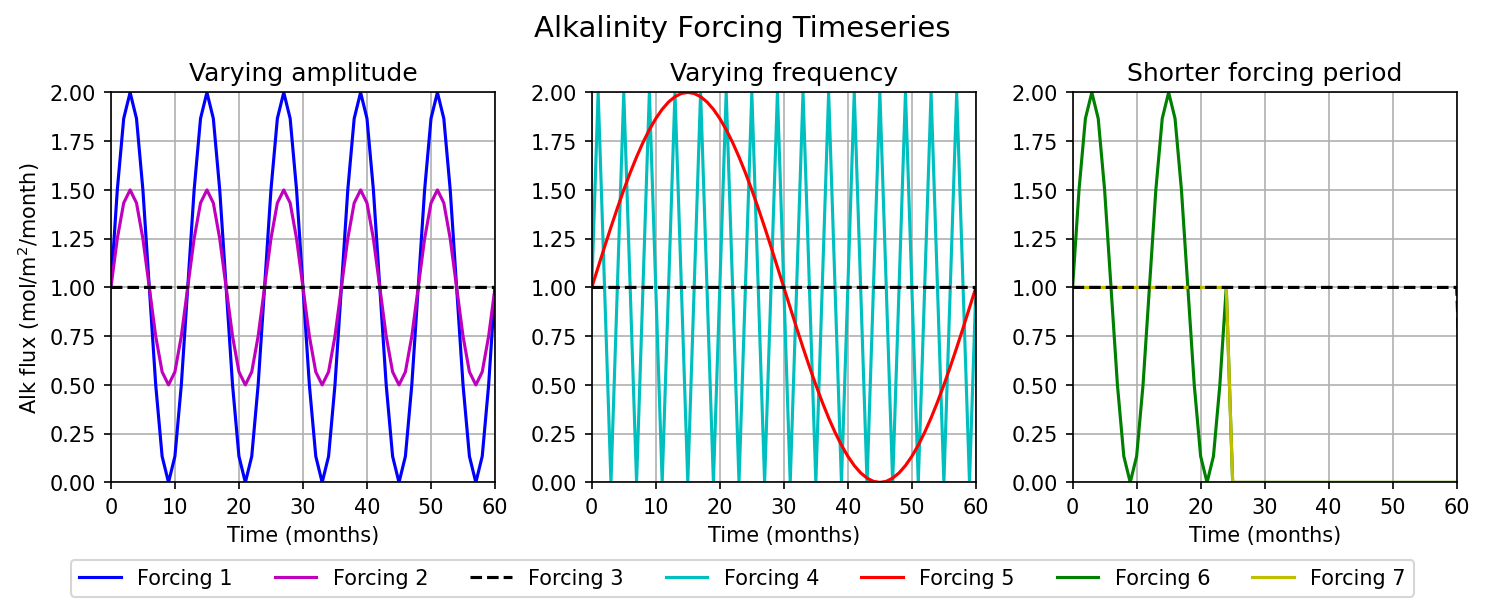

In [239]:
fig=plt.figure(figsize=(10,4),dpi=150)

ftime = np.linspace(0,IRF_length-1,IRF_length)
len_t = nyears*12

#Can modify any of these forcing options
option_1 = np.sin(nyears*ftime*2*np.pi/(len_t))+1;     option_1[len_t+1:]=0.;
option_2 = np.sin(nyears*ftime*2*np.pi/(len_t))*0.5+1; option_2[len_t+1:]=0.;
option_3 = ftime*0+1; option_3[len_t+1:]=0.;           option_3[len_t+1:]=0.;

option_4 = np.sin(15*ftime*2*np.pi/(len_t))+1;         option_4[len_t+1:]=0.;
option_5 = np.sin(1*ftime*2*np.pi/(len_t))+1;          option_5[len_t+1:]=0.;

option_6 = np.sin(5*ftime*2*np.pi/(len_t))+1;          option_6[25:]=0
option_7 = ftime*0+1; option_7[25:]=0


yhi = 2; xhi = len_t
ax1=plt.subplot(1,3,1)
plt.plot(ftime,option_1,'b',label='Forcing 1')
plt.plot(ftime,option_2,'m',label='Forcing 2')
plt.plot(ftime,option_3,'--k',label='Forcing 3')
plt.grid('on'); plt.xlim([0,xhi]); plt.ylim([0,yhi]);
plt.xlabel('Time (months)'); plt.ylabel('Alk flux (mol/m$^2$/month)')
plt.title('Varying amplitude')

ax2=plt.subplot(1,3,2)
plt.plot(ftime,option_4,'c',label='Forcing 4')
plt.plot(ftime,option_5,'r',label='Forcing 5')
plt.plot(ftime,option_3,'--k')

plt.grid('on'); plt.xlim([0,xhi]); plt.ylim([0,yhi]);
plt.xlabel('Time (months)'); 
plt.title('Varying frequency')

ax3=plt.subplot(1,3,3)
plt.plot(ftime,option_6,'g',label='Forcing 6')
plt.plot(ftime,option_7,'y',label='Forcing 7')
plt.plot(ftime,option_3,'--k')

plt.grid('on'); plt.xlim([0,xhi]); plt.ylim([0,yhi]);
plt.xlabel('Time (months)'); 
plt.tight_layout()
plt.title('Shorter forcing period')

fig.legend(loc="lower center",ncol=7) 
plt.tight_layout()
plt.subplots_adjust(bottom=0.2,top=0.85)
plt.suptitle('Alkalinity Forcing Timeseries',fontsize=14)

#plt.savefig('fig1.png')

## We now perform a month-by-month convolution, sum, and normalize to get uptake curve:


In [240]:
convolution_1   = np.zeros(option_1.shape);
convolution_2   = np.zeros(option_2.shape);
convolution_3   = np.zeros(option_3.shape);
convolution_4   = np.zeros(option_4.shape);
convolution_5   = np.zeros(option_5.shape);
convolution_6   = np.zeros(option_6.shape);
convolution_7   = np.zeros(option_7.shape);

for i in range(0,len_t):
    convolution_local = np.convolve(option_1, IRF_full[i])
    convolution_1[i:IRF_length] = convolution_1[i:IRF_length] + convolution_local[0:IRF_length-i]

    convolution_local = np.convolve(option_2, IRF_full[i])
    convolution_2[i:IRF_length] = convolution_2[i:IRF_length] + convolution_local[0:IRF_length-i]

    convolution_local = np.convolve(option_3, IRF_full[i])
    convolution_3[i:IRF_length] = convolution_3[i:IRF_length] + convolution_local[0:IRF_length-i]

    convolution_local = np.convolve(option_4, IRF_full[i])
    convolution_4[i:IRF_length] = convolution_4[i:IRF_length] + convolution_local[0:IRF_length-i]

    convolution_local = np.convolve(option_5, IRF_full[i])
    convolution_5[i:IRF_length] = convolution_5[i:IRF_length] + convolution_local[0:IRF_length-i]

    convolution_local = np.convolve(option_6, IRF_full[i])
    convolution_6[i:IRF_length] = convolution_6[i:IRF_length] + convolution_local[0:IRF_length-i]

    convolution_local = np.convolve(option_7, IRF_full[i])
    convolution_7[i:IRF_length] = convolution_7[i:IRF_length] + convolution_local[0:IRF_length-i]


Text(0.5, 0.98, 'Convolution Results')

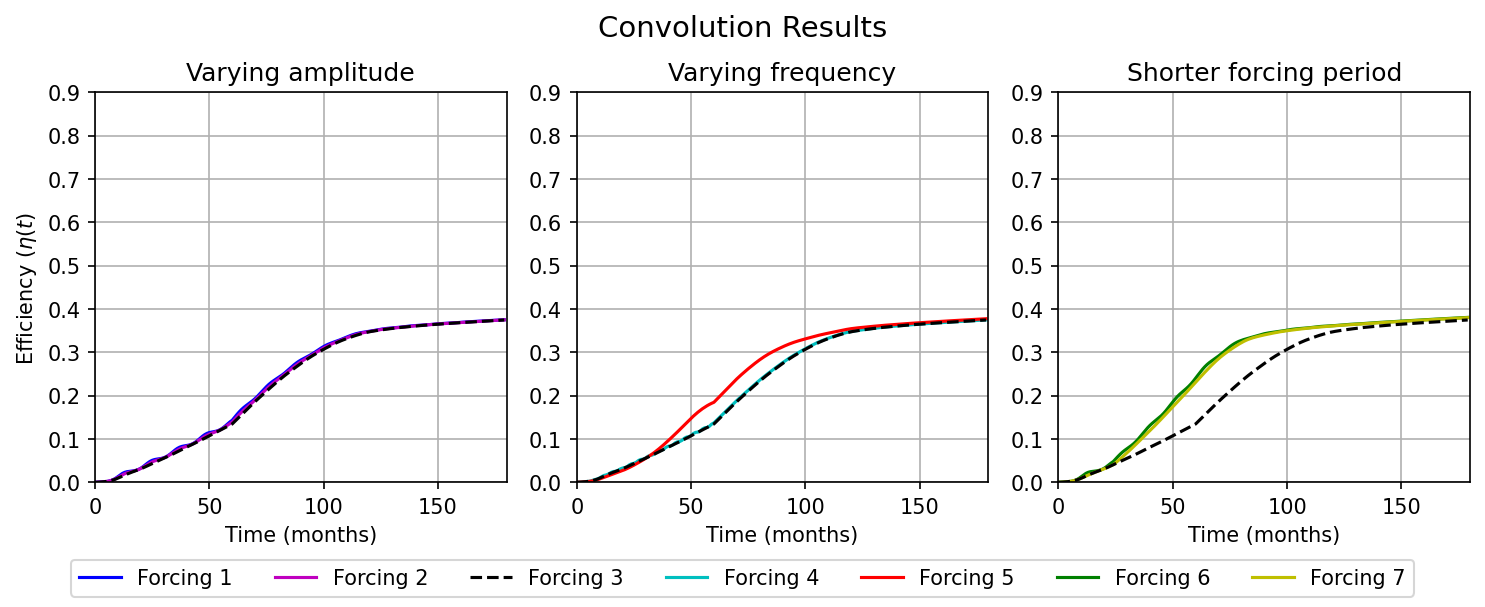

In [241]:
fig=plt.figure(figsize=(10,4),dpi=150)

yhi = .9; xhi = IRF_length
plt.subplot(1,3,1)
plt.plot(ftime,convolution_1/np.cumsum(option_1)/len_t,'b',label= 'Forcing 1') #normalize by length of time in months forcing is applied
plt.plot(ftime,convolution_2/np.cumsum(option_2)/len_t,'m', label= 'Forcing 2')
plt.plot(ftime,convolution_3/np.cumsum(option_3)/len_t,'--k', label= 'Forcing 3')
plt.grid('on'); plt.xlim([0,xhi]); plt.ylim([0,yhi]);
plt.xlabel('Time (months)'); plt.ylabel('Efficiency ($\eta(t)$')
plt.title('Varying amplitude')

plt.subplot(1,3,2)
plt.plot(ftime,convolution_4/np.cumsum(option_4)/len_t,'c', label= 'Forcing 4')
plt.plot(ftime,convolution_5/np.cumsum(option_5)/len_t,'r', label= 'Forcing 5')
plt.plot(ftime,convolution_3/np.cumsum(option_3)/len_t,'--k')

plt.grid('on'); plt.xlim([0,xhi]); plt.ylim([0,yhi]);
plt.xlabel('Time (months)'); 
plt.title('Varying frequency')

plt.subplot(1,3,3)
plt.plot(ftime,convolution_6/np.cumsum(option_6)/len_t,'g',label= 'Forcing 6')
plt.plot(ftime,convolution_7/np.cumsum(option_7)/len_t,'y', label= 'Forcing 7')
plt.plot(ftime,convolution_3/np.cumsum(option_3)/len_t,'--k')

plt.grid('on'); plt.xlim([0,xhi]); plt.ylim([0,yhi]);
plt.xlabel('Time (months)'); 
plt.title('Shorter forcing period')

fig.legend(loc="lower center",ncol=7) 
plt.tight_layout()
plt.subplots_adjust(bottom=0.2,top=0.85)
plt.suptitle('Convolution Results',fontsize=14)
#plt.savefig('fig2.png')